In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchaudio.functional import equalizer_biquad
from standalone import HiPPO

In [3]:
sample_rates = [
    16_000, 
    20_000, 
    32_000, 
    44_100, 
    48_000,
    96_000
]
base_rate = 48_000

The training set for this experiment is randomly synthesized signals reproduced across different sample rates.
The alternative is to use real audio and resample it, but for our purposes -- introducing the HiPPO method and demonstrating its viability -- this is sufficient.  This method also has the advantage of an "infinite" dataset with zero resampling error.

In [4]:
# choose some number of frequency components and add them together to form 2*pi seconds of signal
least_num_freqs = 4
most_num_freqs = 16
num_freqs = np.random.randint(least_num_freqs, most_num_freqs + 1)
sine_parameters = [ (np.random.randint(1, min(sample_rates) / 2), # freq in [1, nyquist)
                     np.random.random(),                          # amplitude in [0, 1)
                     np.random.random() * np.pi)                  # phase shift in [0, pi)
                    for _ in range(num_freqs) ]

signals = dict()
for sr in sample_rates:
    x = np.arange(0, 2*np.pi, 1/sr)
    ys = []
    for f, A, phi in sine_parameters:
        y = A * np.sin(f*x + phi)      # generate sine wave
        ys.append(y)                   # store in list
    y = np.stack(ys).sum(axis=0)       # sum all sine waves
    y /= np.abs(y).max()               # normalize to [-1, 1]
    signals[sr] = y

These plots show that we are looking at the same underlying continuous signal.

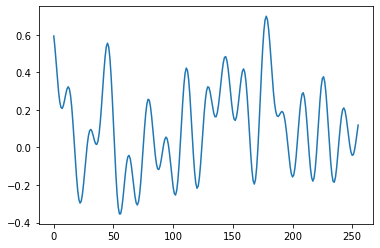

In [5]:
plt.plot(signals[16_000][:256])

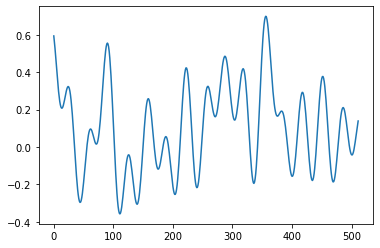

In [6]:
plt.plot(signals[32_000][:512])

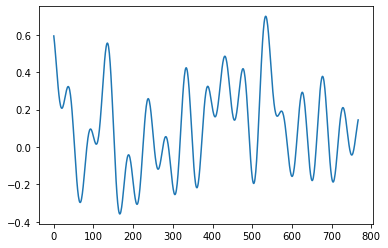

In [7]:
plt.plot(signals[48_000][:768])

In [8]:
# package the signal generation into a function that returns a dict of (sample_rate, signal) pairs

def generate_signals_dict(sample_rates, least_num_freqs=4, most_num_freqs=16):
    num_freqs = np.random.randint(least_num_freqs, most_num_freqs + 1)
    sine_parameters = [ (np.random.randint(1, min(sample_rates) / 2), # freq in [1, nyquist)
                         np.random.random(),                          # amplitude in [0, 1)
                         np.random.random() * np.pi)                  # phase shift in [0, pi)
                        for _ in range(num_freqs) ]

    signals = dict()
    for sr in sample_rates:
        x = np.arange(0, 2*np.pi, 1/sr)
        ys = []
        for f, A, phi in sine_parameters:
            y = A * np.sin(f*x + phi)      # generate sine wave
            ys.append(y)                   # store in list
        y = np.stack(ys).sum(axis=0)       # sum all sine waves
        y /= np.abs(y).max()               # normalize to [-1, 1]
        signals[sr] = y
    return signals

We'll task a single model with learning a particular filter / chain of filters.  The weights in this model will be used for all sample rates.

In [14]:
def apply_eq(x, sample_rate):
    y = equalizer_biquad(x, sample_rate=sample_rate, center_freq=80, gain=-3)
    y = equalizer_biquad(y, sample_rate=sample_rate, center_freq=400, gain=-6)
    y = equalizer_biquad(y, sample_rate=sample_rate, center_freq=1500, gain=2)
    return y

In [10]:
dim = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = nn.Sequential(
    nn.Linear(dim, dim),
    nn.Dropout(p=0.1),   
    nn.ReLU(),
    nn.Linear(dim, 1)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_func = nn.functional.mse_loss

chunk_size = 512
epochs = 15
train_pct = 0.8

for epoch in range(1, epochs + 1):
    signals = generate_signals_dict(sample_rates)

    # randomize the order of training
    shuffled_sample_rates = list(signals.keys())
    random.shuffle(shuffled_sample_rates)
    
    overall_losses = []
    print(f"Epoch: {epoch}")
    for sample_rate in shuffled_sample_rates:
        # retrieve time series that corresponds to this sample rate
        # then tensorize, process, split into buffers, and shuffle
        signal = signals[sample_rate]
        x = torch.tensor(signal, dtype=torch.float32)
        y = apply_eq(x, sample_rate)
        xs = torch.split(x, chunk_size)[:-1] # drop last chunk
        ys = torch.split(y, chunk_size)[:-1]
        xys = list(zip(xs, ys))
        random.shuffle(xys)
        
        # train valid split
        num_train = int(len(xys) * train_pct)
        train_xys = xys[:num_train]
        valid_xys = xys[num_train:]
        
        # create a new HiPPO for this particular sample rate
        # dt controls the context window
        hippo = HiPPO(dim, dt=sample_rate/base_rate)
        hippo.to(device)

        model.train()
        for x, y in train_xys:
            x = x.to(device)
            y = y.to(device)
            with torch.no_grad():
                hippo_out = hippo(x)
            y_hat = model(hippo_out).squeeze()
            loss = loss_func(y_hat, y)
            loss.backward()
            opt.step()
            opt.zero_grad()        

        losses = []
        model.eval()
        for x, y in valid_xys:
            x = x.to(device)
            y = y.to(device)
            with torch.no_grad():
                hippo_out = hippo(x)
            y_hat = model(hippo_out).squeeze()
            loss = loss_func(y_hat, y)
            losses.append(loss)
        loss = torch.stack(losses).mean()
        overall_losses.append(loss)
        print(f"\tSample rate: {sample_rate}\tLoss: {loss.item():.6f}")
    overall_loss = torch.stack(overall_losses).mean()
    print(f"\n\tAverage Loss: {overall_loss.item():.4f}\n")

Epoch: 1
	Sample rate: 16000	Loss: 0.092940
	Sample rate: 48000	Loss: 0.072438
	Sample rate: 32000	Loss: 0.053642
	Sample rate: 20000	Loss: 0.051961
	Sample rate: 44100	Loss: 0.032120
	Sample rate: 96000	Loss: 0.022474

	Average Loss: 0.0543

Epoch: 2
	Sample rate: 44100	Loss: 0.005889
	Sample rate: 96000	Loss: 0.006611
	Sample rate: 20000	Loss: 0.009243
	Sample rate: 32000	Loss: 0.004304
	Sample rate: 16000	Loss: 0.010920
	Sample rate: 48000	Loss: 0.005180

	Average Loss: 0.0070

Epoch: 3
	Sample rate: 20000	Loss: 0.004288
	Sample rate: 32000	Loss: 0.002570
	Sample rate: 48000	Loss: 0.003091
	Sample rate: 96000	Loss: 0.003623
	Sample rate: 44100	Loss: 0.002566
	Sample rate: 16000	Loss: 0.005276

	Average Loss: 0.0036

Epoch: 4
	Sample rate: 96000	Loss: 0.007406
	Sample rate: 48000	Loss: 0.004462
	Sample rate: 16000	Loss: 0.009658
	Sample rate: 44100	Loss: 0.003781
	Sample rate: 32000	Loss: 0.003405
	Sample rate: 20000	Loss: 0.006868

	Average Loss: 0.0059

Epoch: 5
	Sample rate: 96000

Now test against sample rates not seen during training.

In [13]:
test_sample_rates = [22050, 88200]
signals = generate_signals_dict(test_sample_rates)
    
for sample_rate, signal in signals.items():
    x = torch.tensor(signal, dtype=torch.float32)
    y = apply_eq(x, sample_rate)
    hippo = HiPPO(dim, dt=sample_rate/base_rate)
    hippo.to(device)
    
    losses = []
    model.eval()
    for x, y in valid_xys:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            hippo_out = hippo(x)
        y_hat = model(hippo_out).squeeze()
        loss = loss_func(y_hat, y)
        losses.append(loss)
    loss = torch.stack(losses).mean()
    print(f"Sample rate: {sample_rate}\tLoss: {loss.item():.6f}")

Sample rate: 22050	Loss: 0.001310
Sample rate: 88200	Loss: 0.002120
